# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from datetime import datetime
import rpy2
import os
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython

from preprocessing_all_points import *
from preprocessing_points_spatially_temporally import *
from compile_model_t import *

# Load the data

In [3]:
# Import and preprocess data
df_lagoon_profiles,df_ocean_profiles,inundation_dict,winds_dict,waves_dict,tide_dict,sla_dict,time_dict = \
    loading_tarawa_data()

In [4]:
df_ocean,df_lagoon = preprocessing_points_spatially()
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon(df_lagoon)
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean(df_ocean)

# Testing Code

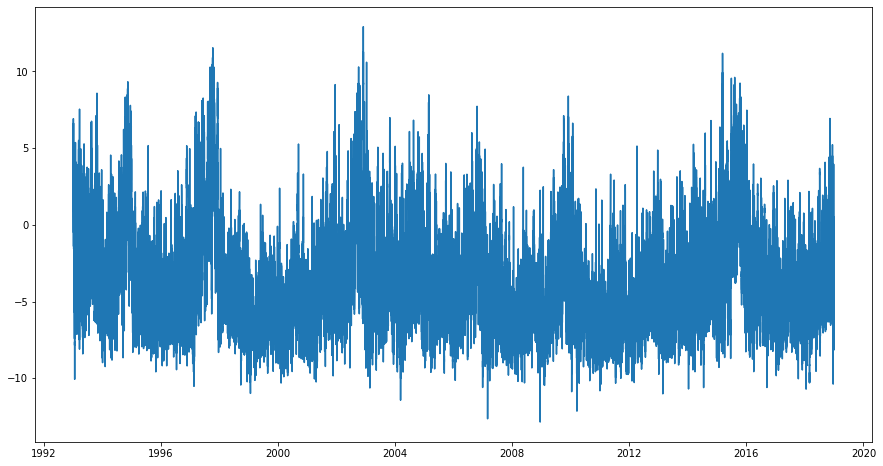

In [5]:
plt.figure(figsize=(15,8))
plt.plot(time_dict['time'],winds_dict['wind_u'])

In [6]:
from sklearn.cluster import KMeans

In [7]:
df_winds = pd.DataFrame.from_dict({**winds_dict},orient='index').T
test = df_winds.to_numpy()
km = KMeans(n_clusters=4).fit(test)

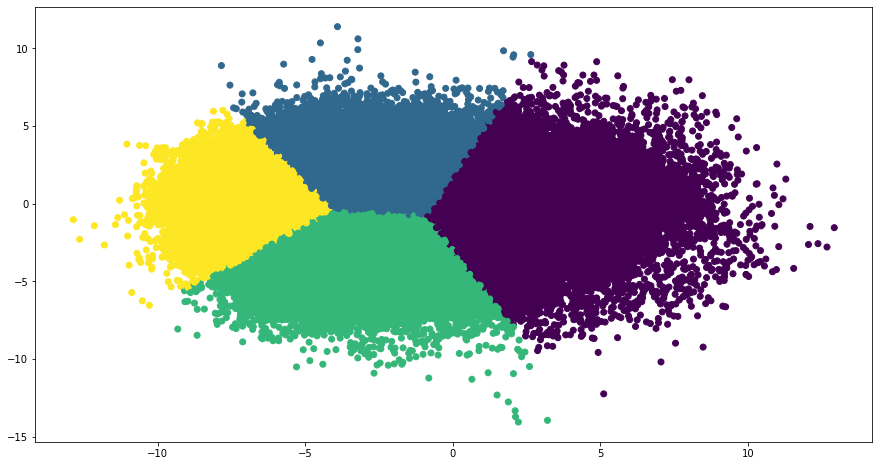

In [8]:
fig = plt.figure(figsize=(15,8))

plt.scatter(df_winds['wind_u'],df_winds['wind_v'],c=km.labels_)

plt.show()

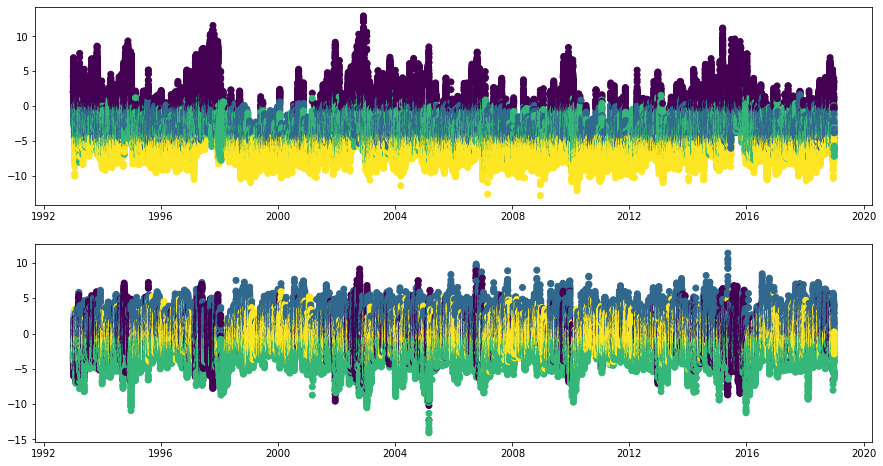

In [9]:
fig = plt.figure(figsize=(15,8))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(time_dict['time'],df_winds['wind_u'],c=km.labels_)
ax2.scatter(time_dict['time'],df_winds['wind_v'],c=km.labels_)

plt.show()

In [10]:
df_all_data = pd.DataFrame.from_dict({**winds_dict,**waves_dict},orient='index').T

/tmp/ipykernel_42/3633982892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ocean_wind_wave[col] = (max_col-df_ocean_wind_wave[col])/(max_col-min_col)
/tmp/ipykernel_42/3633982892.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ocean_wind_wave['clusters'] = km.labels_
/tmp/ipykernel_42/3633982892.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

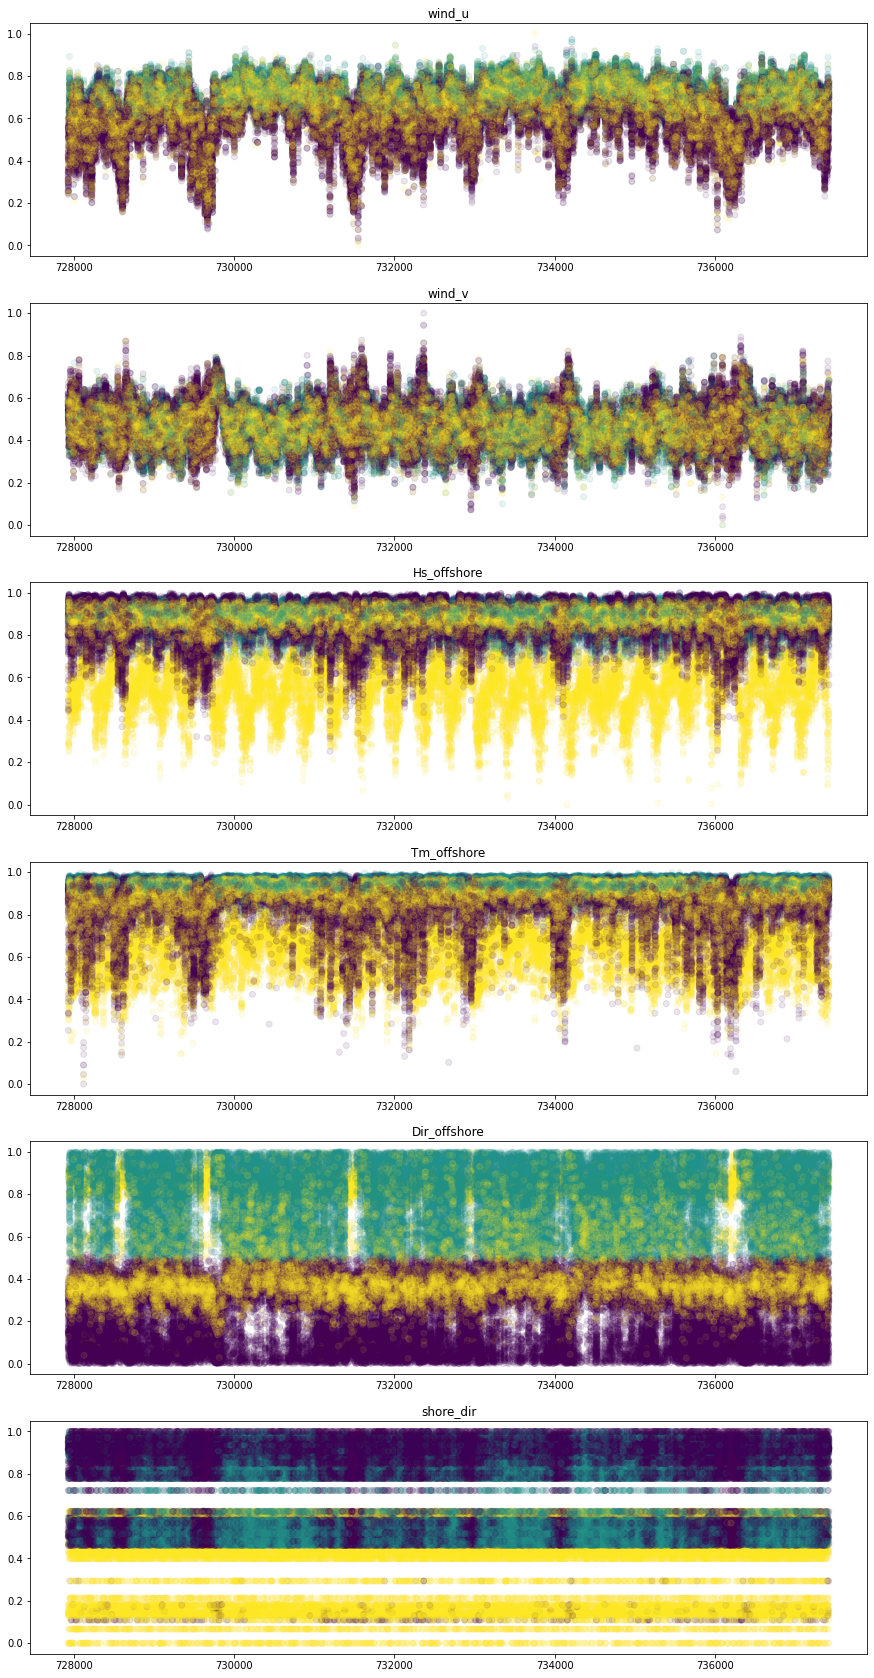

In [11]:
df_ocean_wind_wave = df_ocean[['wind_u','wind_v','Hs_offshore','Tm_offshore','Dir_offshore','shore_dir']]

for col in list(df_ocean_wind_wave):
    max_col = np.max(df_ocean_wind_wave[col])
    min_col = np.min(df_ocean_wind_wave[col])
    df_ocean_wind_wave[col] = (max_col-df_ocean_wind_wave[col])/(max_col-min_col)

test = df_ocean_wind_wave.to_numpy()
km = KMeans(n_clusters=3).fit(test)

fig = plt.figure(figsize=(15,30))

ax1 = plt.subplot2grid((6,1),(0,0))
ax2 = plt.subplot2grid((6,1),(1,0))
ax3 = plt.subplot2grid((6,1),(2,0))
ax4 = plt.subplot2grid((6,1),(3,0))
ax5 = plt.subplot2grid((6,1),(4,0))
ax6 = plt.subplot2grid((6,1),(5,0))

for ax,var in zip([ax1,ax2,ax3,ax4,ax5,ax6],list(df_ocean_wind_wave)):
    ax.scatter(df_ocean.time,df_ocean_wind_wave[var],c=km.labels_,alpha=0.1)
    ax.set_title(var)
    
df_ocean_wind_wave['clusters'] = km.labels_
df_ocean_wind_wave['time'] = df_ocean.time
df_ocean_wind_wave['time'] = [(datetime.fromordinal(int(time)-366)+timedelta(days=time%1)) for time in df_ocean['time']]
df_ocean_wind_wave = df_ocean_wind_wave.sort_values('time')

In [12]:
df_day = df_ocean_wind_wave[(df_ocean_wind_wave.time>=datetime(1993,1,1,0,0,0))&(df_ocean_wind_wave.time<datetime(1993,1,2,0,0,0))]

In [13]:
# for index,group in df_day.groupby('clusters'):
#     !R -i df_day
#     !R summary(df_day)



ARGUMENT 'df_day' __ignored__


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> 
> 
> /usr/bin/sh: 1: Syntax error: "(" unexpected

ARGUMENT 'df_day' __ignored__


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute 

KeyboardInterrupt: 

In [ ]:
# %%R -i df_ocean_wind_wave

# summary(df_ocean_wind_wave)

# Find "King tide" events

In [26]:
fig = plt.figure(figsize=(15,7))

ax1 = plt.subplot2grid((1,1),(0,0))

ax1.plot(time_dict['time'],tide_dict['Tide'])

ax1.scatter(np.array(time_dict['time'])[tide_dict['Tide']>1.2],tide_dict['Tide'][tide_dict['Tide']>1.2],c='k')

plt.show()

# Large Wave Periods

In [101]:
# First, group the shorelines into faceing different directions

In [107]:
lats = [x[0] for x in inundation_dict['Ptos']]
longs = [x[1] for x in inundation_dict['Ptos']]


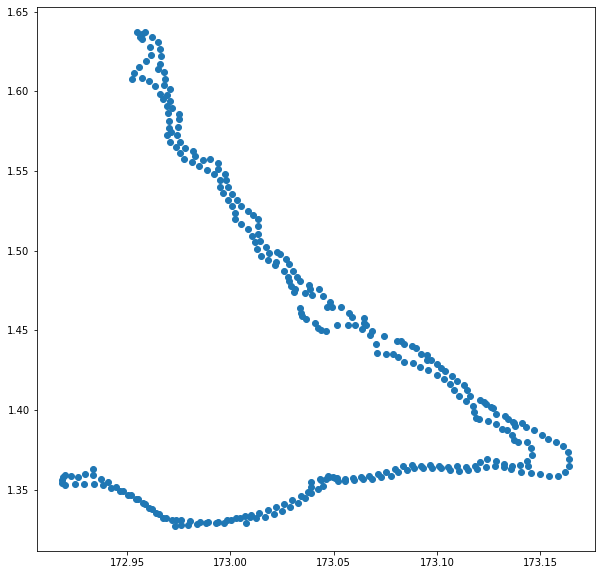

In [108]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(lats,longs)

plt.show()


In [114]:
df_ocean_coords = df_ocean[['lat','long','shore_dir']]
df_ocean_coords = df_ocean_coords.drop_duplicates()

df_ocean_coords

lat       long   shore_dir
0       1.359241  172.92001  319.061643
1000    1.356421  172.91848  272.206588
2000    1.353139  172.92019  188.726378
3000    1.353647  172.92488  181.362270
4000    1.353986  172.92935  177.157178
...          ...        ...         ...
170932  1.357814  172.91907  298.809736
171932  1.354158  172.91862  246.268673
172932  1.636152  172.95727  340.506556
173932  1.356990  173.04626  158.526428
174932  1.357409  173.05073  174.640023

[176 rows x 3 columns]

In [109]:
# For an example point, have a look at how the wave height, period and direction have changed

In [71]:
wave_period = waves_dict['Tmo'][:,0]
wave_height = waves_dict['Hso'][:,0]
wave_time = np.array(waves_dict['Timeo'])


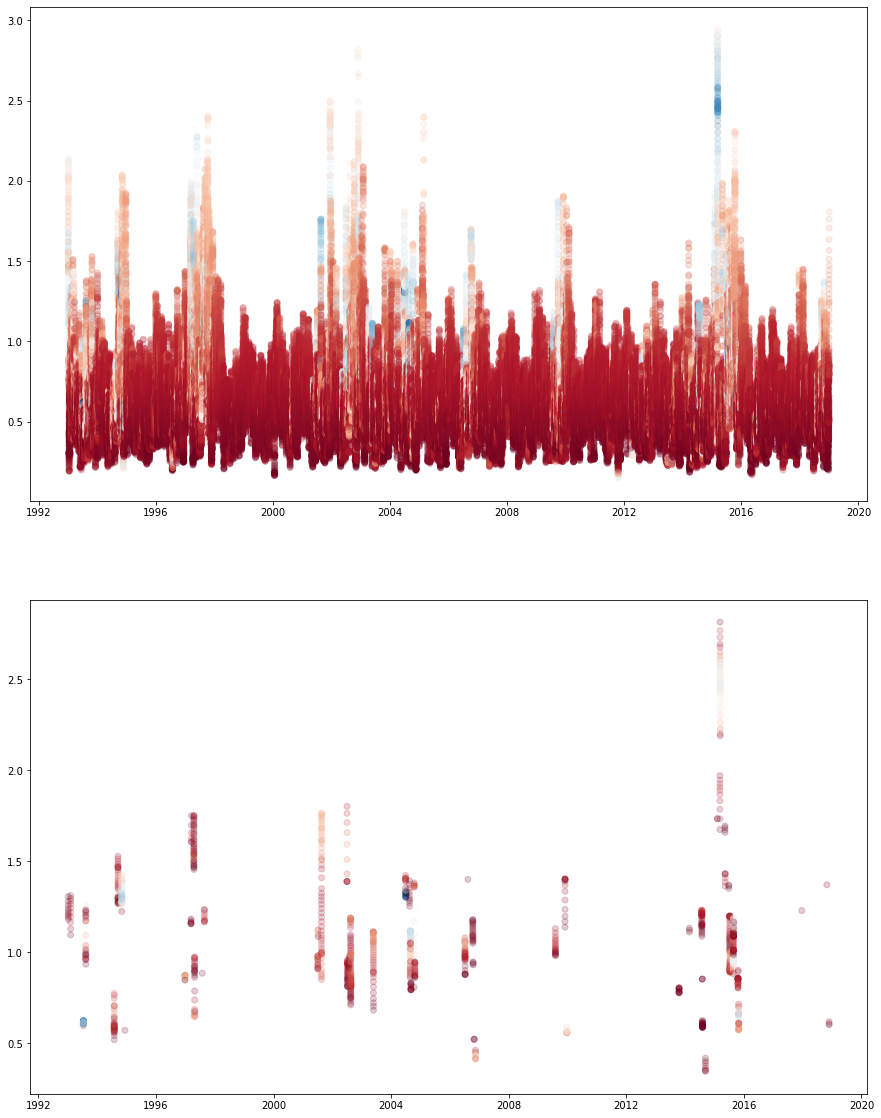

In [72]:
fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(wave_time,wave_height,c=wave_period,alpha=0.2,cmap='RdBu')

max_wave_period = 8
storm_wave_period = wave_period[wave_period>max_wave_period]
storm_wave_height = wave_height[wave_period>max_wave_period]
storm_time = wave_time[wave_period>max_wave_period]


ax2.scatter(storm_time,storm_wave_height,c=storm_wave_period,alpha=0.2,cmap='RdBu')

plt.show()

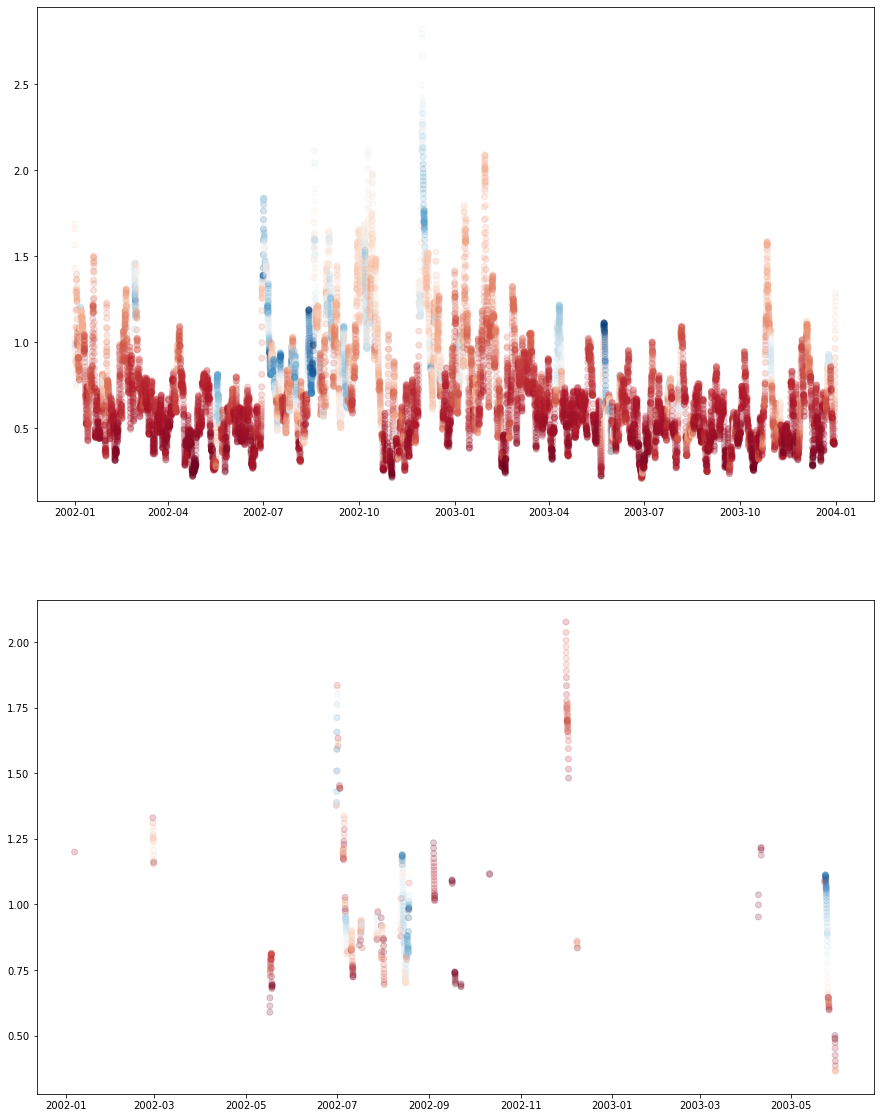

In [99]:
start_year = 2002
end_year = 2004

wave_time_slice = np.array([time for time in wave_time if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])
wave_height_slice = np.array([height for height,time in zip(wave_height,wave_time)\
                     if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])
wave_period_slice = np.array([period for period,time in zip(wave_period,wave_time)\
                     if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])

fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(wave_time_slice,wave_height_slice,c=wave_period_slice,alpha=0.2,cmap='RdBu')

max_wave_period = 7
storm_wave_period = wave_period_slice[wave_period_slice>max_wave_period]
storm_wave_height = wave_height_slice[wave_period_slice>max_wave_period]
storm_time = wave_time_slice[wave_period_slice>max_wave_period]


ax2.scatter(storm_time,storm_wave_height,c=storm_wave_period,alpha=0.2,cmap='RdBu')

plt.show()

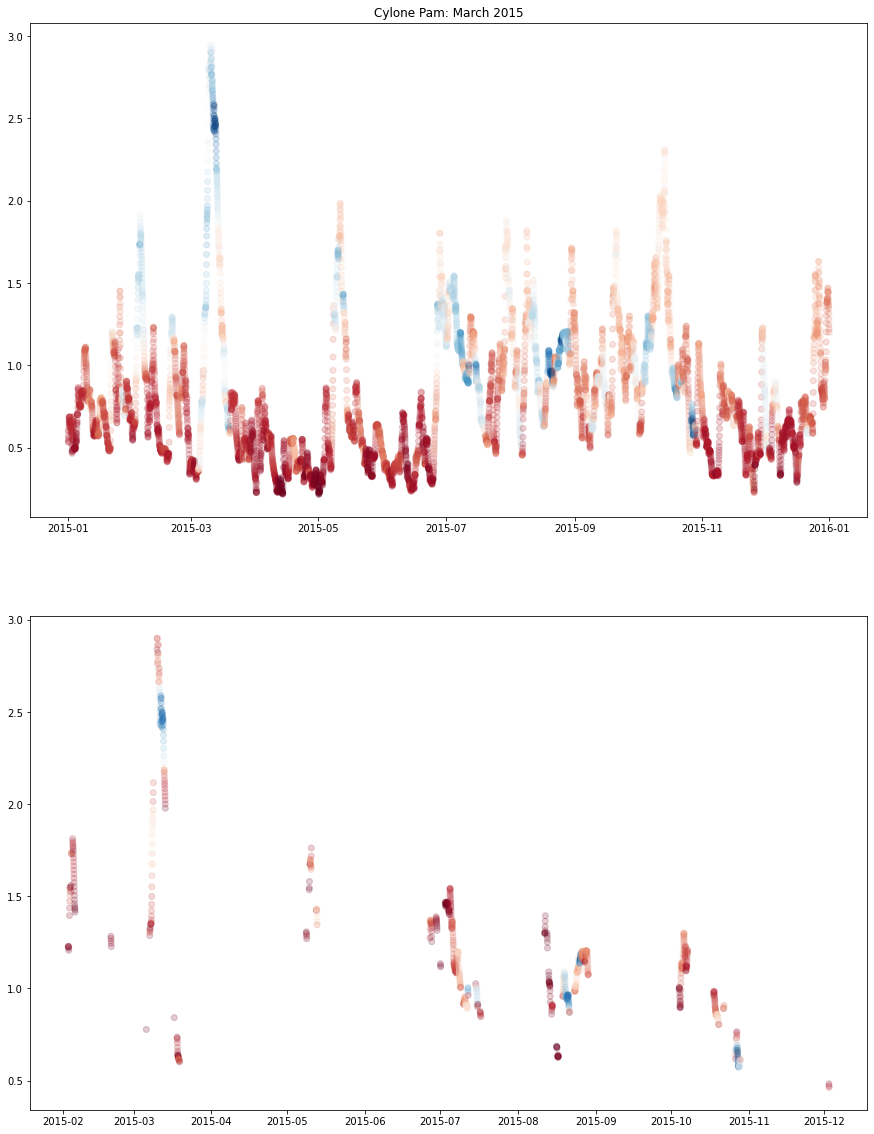

In [100]:
start_year = 2015
end_year = 2016

wave_time_slice = np.array([time for time in wave_time if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])
wave_height_slice = np.array([height for height,time in zip(wave_height,wave_time)\
                     if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])
wave_period_slice = np.array([period for period,time in zip(wave_period,wave_time)\
                     if ((time>datetime(start_year,1,1,0,0))&(time<datetime(end_year,1,1,0,0))) ])

fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(wave_time_slice,wave_height_slice,c=wave_period_slice,alpha=0.2,cmap='RdBu')

max_wave_period = 7
storm_wave_period = wave_period_slice[wave_period_slice>max_wave_period]
storm_wave_height = wave_height_slice[wave_period_slice>max_wave_period]
storm_time = wave_time_slice[wave_period_slice>max_wave_period]


ax2.scatter(storm_time,storm_wave_height,c=storm_wave_period,alpha=0.2,cmap='RdBu')

ax1.set_title('Cylone Pam: March 2015')

plt.show()

# Cyclones
- March 2015; cyclone Pam (6-20th)
- 



In [62]:
fig = plt.figure(figsize=(15,20))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

ax1.scatter(time_dict['time'],waves_dict['Hso'][:,0],c=waves_dict['Tmo'][:,0],alpha=0.2,cmap='RdBu')

max_wave_period = 8
storm_wave_period = waves_dict['Tmo'][:,0][waves_dict['Tmo'][:,0]>max_wave_period]
storm_wave_height = waves_dict['Hso'][:,0][waves_dict['Tmo'][:,0]>max_wave_period]
storm_time = np.array(waves_dict['Timeo'])[waves_dict['Tmo'][:,0]>max_wave_period]


ax2.scatter(storm_time,storm_wave_height,c=storm_wave_period,alpha=0.5)

plt.show()

array([datetime.datetime(1993, 1, 1, 0, 0),
       datetime.datetime(1993, 1, 1, 0, 59, 59, 999997),
       datetime.datetime(1993, 1, 1, 2, 0, 0, 3), ...,
       datetime.datetime(2018, 11, 26, 20, 0, 0, 3),
       datetime.datetime(2018, 11, 26, 21, 0),
       datetime.datetime(2018, 11, 26, 21, 59, 59, 999997)], dtype=object)

In [61]:
waves_dict['Timeo']

[datetime.datetime(1993, 1, 1, 0, 0),
 datetime.datetime(1993, 1, 1, 0, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 2, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 3, 0),
 datetime.datetime(1993, 1, 1, 3, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 5, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 6, 0),
 datetime.datetime(1993, 1, 1, 6, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 8, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 9, 0),
 datetime.datetime(1993, 1, 1, 9, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 11, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 12, 0),
 datetime.datetime(1993, 1, 1, 12, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 14, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 15, 0),
 datetime.datetime(1993, 1, 1, 15, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 17, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 18, 0),
 datetime.datetime(1993, 1, 1, 18, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 20, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 21, 0),
 datetime.datetime(1

array([1.22656677, 1.20895256, 1.23063553, 1.2045477 , 1.20288126,
       1.20560288, 1.21349506, 1.20343218, 1.20055588, 1.24178494,
       1.20341142, 1.21304665, 1.21070459, 1.21197647, 1.20252206,
       1.22661574, 1.22757784])

array([datetime.datetime(1993, 2, 7, 5, 0, 0, 3),
       datetime.datetime(1996, 1, 21, 5, 0, 0, 3),
       datetime.datetime(1997, 2, 8, 5, 0, 0, 3),
       datetime.datetime(1998, 2, 27, 5, 0, 0, 3),
       datetime.datetime(2001, 2, 8, 5, 0, 0, 3),
       datetime.datetime(2001, 8, 19, 17, 0, 0, 3),
       datetime.datetime(2002, 2, 27, 5, 0, 0, 3),
       datetime.datetime(2002, 9, 7, 17, 0, 0, 3),
       datetime.datetime(2006, 1, 30, 5, 0, 0, 3),
       datetime.datetime(2006, 2, 28, 5, 0, 0, 3),
       datetime.datetime(2007, 2, 18, 5, 0, 0, 3),
       datetime.datetime(2010, 1, 30, 5, 0, 0, 3),
       datetime.datetime(2010, 1, 31, 5, 0, 0, 3),
       datetime.datetime(2010, 8, 10, 17, 0, 0, 3),
       datetime.datetime(2014, 1, 2, 5, 0, 0, 3),
       datetime.datetime(2014, 1, 31, 5, 0, 0, 3),
       datetime.datetime(2015, 2, 19, 5, 0, 0, 3)], dtype=object)

In [20]:
time_dict['time']

[datetime.datetime(1993, 1, 1, 0, 0),
 datetime.datetime(1993, 1, 1, 0, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 2, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 3, 0),
 datetime.datetime(1993, 1, 1, 3, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 5, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 6, 0),
 datetime.datetime(1993, 1, 1, 6, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 8, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 9, 0),
 datetime.datetime(1993, 1, 1, 9, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 11, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 12, 0),
 datetime.datetime(1993, 1, 1, 12, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 14, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 15, 0),
 datetime.datetime(1993, 1, 1, 15, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 17, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 18, 0),
 datetime.datetime(1993, 1, 1, 18, 59, 59, 999997),
 datetime.datetime(1993, 1, 1, 20, 0, 0, 3),
 datetime.datetime(1993, 1, 1, 21, 0),
 datetime.datetime(1

In [21]:
tide_dict['Tide']

array([ 0.11754664, -0.01880866, -0.13627197, ..., -0.30936497,
       -0.08429388,  0.1718647 ])